# <center>Exploratory Data Analysis on the OWID COVID-19 Dataset</center>
<hr>

## <center>1. Reader's guide 📝</center>
***
This section aims to elaborate on the data we will be handling as well as the end goal of the notebook.

### 1.1 Introduction
<br>
This notebook servers as an Exploratory Data Analysis (EDA) on the data provided by <a href="https://ourworldindata.org/">OWID</a> (Our World in Data). This data contains the information about the COVID-19 pandemic for every day for all the countries that recorded data.

### 1.2 Goal of the document
<br>
The goal of this notebook is to explore and visualize trends in the data as well as what it provides. This notebook will also act as a preparation notebook for time-series modelling.
<hr>

## <center>2. Introducing the data 🔎</center>
***  
This section aims to thoroughly research and reshape the data where needed.

### 2.1 Loading in & glancing over the data

Firstly, we will import the libraries required for the task of data wrangling and visualization.

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from colorama import Fore

import math

import datetime
from datetime import date

np.random.seed(21)

Next we load in and inspect the shape of the data.

In [2]:
df = pd.read_csv('./data/covid-data.csv')

In [3]:
df.shape

(84310, 59)

We have __84 310__ rows with __59__ columns.
***
Now we can look at what the data contains.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84310 entries, 0 to 84309
Data columns (total 59 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   iso_code                               84310 non-null  object 
 1   continent                              80235 non-null  object 
 2   location                               84310 non-null  object 
 3   date                                   84310 non-null  object 
 4   total_cases                            82276 non-null  float64
 5   new_cases                              82274 non-null  float64
 6   new_cases_smoothed                     81273 non-null  float64
 7   total_deaths                           72644 non-null  float64
 8   new_deaths                             72802 non-null  float64
 9   new_deaths_smoothed                    81273 non-null  float64
 10  total_cases_per_million                81831 non-null  float64
 11  ne

In [5]:
df['date'].min()

'2020-01-01'

In [6]:
df['date'].max()

'2021-04-26'

Looks like the data contains a wide variety of criteria that can be inspected through the <a href="https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-codebook.csv">official documentation</a>. We can also see that the data ranges from __2020-01-01__ until __2021-04-26__. From the documentation it is also known that the data is updated daily.
***
Next we can look into duplicated or null values.

In [7]:
df.isnull().sum()

iso_code                                     0
continent                                 4075
location                                     0
date                                         0
total_cases                               2034
new_cases                                 2036
new_cases_smoothed                        3037
total_deaths                             11666
new_deaths                               11508
new_deaths_smoothed                       3037
total_cases_per_million                   2479
new_cases_per_million                     2481
new_cases_smoothed_per_million            3477
total_deaths_per_million                 12098
new_deaths_per_million                   11940
new_deaths_smoothed_per_million           3477
reproduction_rate                        16096
icu_patients                             75538
icu_patients_per_million                 75538
hosp_patients                            73724
hosp_patients_per_million                73724
weekly_icu_ad

In [8]:
df.duplicated().sum()

0

We can see that there are no duplicated values but there are some missing records from within the other columns. We will see which of them are relevant and we will find a way to fill them in.
***
Next we can look into the countries with the most and the countries with least amount of confirmed cases. We will limit that number to 10 for ease of visualization.

In [9]:
grouping_cc = df.groupby(['location', 'continent', 'date'])['total_cases'].sum()
grouping_r = grouping_cc.groupby(['location', 'continent']).max()
df_f = pd.DataFrame(grouping_r.groupby(['location']).sum().sort_values(ascending=False))
df_f = df_f.fillna('NA')

In [10]:
highest_10 = df_f.head(10)
lowest_10 = df_f.tail(10)

In [11]:
highest_10

,total_cases
location,
United States,32124869.0
India,17636186.0
Brazil,14369423.0
France,5565080.0
Russia,4717321.0
Turkey,4667281.0
United Kingdom,4422562.0
Italy,3971114.0
Spain,3488469.0


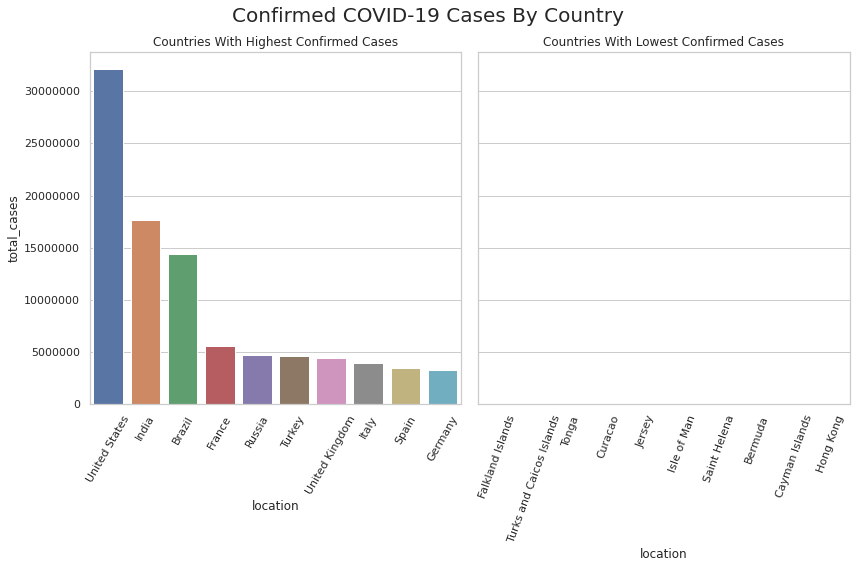

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12,8), sharey=True)
fig.suptitle('Confirmed COVID-19 Cases By Country', size=20)
sns.barplot(ax=ax[0],data=highest_10, x=highest_10.index, y='total_cases')
ax[0].ticklabel_format(style='plain', axis='y')
ax[0].set_title('Countries With Highest Confirmed Cases')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=60)

sns.barplot(ax=ax[1],data=lowest_10, x=lowest_10.index, y='total_cases')
ax[1].ticklabel_format(style='plain', axis='y')
ax[1].set_title('Countries With Lowest Confirmed Cases')
ax[1].set_ylabel('')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=70)

fig.tight_layout()

In the graph above, we have visualized the countries with most and the countries with least amount of confirmed cases. By a huge margin, US has the most confirmed cases, albeit the pandemic began in China that is not in this graph.
***
Now we will naively create a new `DataFrame` object that contains only the features we are currently interested in. Those are the confirmed cases, vaccination efforts, hospitalizations, deaths, testing, and most importantly, strictness of the lockdown. We will be working with data for _The Netherlands_.

In [13]:
df_n = df[['date', 'location', 'total_cases', 'people_vaccinated', 'people_fully_vaccinated', 'hosp_patients','total_deaths' , 'total_tests', 'stringency_index']].copy()
df_n = df_n[df_n['location'] == 'Netherlands']
df_n.head(10)

,date,location,total_cases,people_vaccinated,people_fully_vaccinated,hosp_patients,total_deaths,total_tests,stringency_index
53399,2020-02-27,Netherlands,1.0,NaN,NaN,1.0,NaN,NaN,5.56
53400,2020-02-28,Netherlands,1.0,NaN,NaN,9.0,NaN,NaN,5.56
53401,2020-02-29,Netherlands,6.0,NaN,NaN,10.0,NaN,NaN,5.56
53402,2020-03-01,Netherlands,10.0,NaN,NaN,20.0,NaN,NaN,5.56
53403,2020-03-02,Netherlands,18.0,NaN,NaN,34.0,NaN,NaN,5.56
53404,2020-03-03,Netherlands,24.0,NaN,NaN,40.0,NaN,NaN,5.56
53405,2020-03-04,Netherlands,38.0,NaN,NaN,53.0,NaN,NaN,5.56
53406,2020-03-05,Netherlands,82.0,NaN,NaN,65.0,NaN,NaN,5.56
53407,2020-03-06,Netherlands,128.0,NaN,NaN,77.0,1.0,NaN,11.11
53408,2020-03-07,Netherlands,188.0,NaN,NaN,93.0,1.0,NaN,11.11


We will also parse the `date` column since this is a time-series problem.

In [14]:
df_n['date'] = pd.to_datetime(df_n['date'])

In [15]:
# Remove old rows
df_n = df_n[df_n['total_deaths'].notna() & df_n['total_cases'].notna()].reset_index(drop=True)
df_n.head(1000)

,date,location,total_cases,people_vaccinated,people_fully_vaccinated,hosp_patients,total_deaths,total_tests,stringency_index
0,2020-03-06,Netherlands,128.0,NaN,NaN,77.0,1.0,NaN,11.11
1,2020-03-07,Netherlands,188.0,NaN,NaN,93.0,1.0,NaN,11.11
2,2020-03-08,Netherlands,265.0,NaN,NaN,108.0,3.0,NaN,11.11
3,2020-03-09,Netherlands,321.0,NaN,NaN,141.0,3.0,NaN,11.11
4,2020-03-10,Netherlands,382.0,NaN,NaN,174.0,4.0,NaN,20.83
5,2020-03-11,Netherlands,503.0,NaN,NaN,215.0,5.0,NaN,20.83
6,2020-03-12,Netherlands,503.0,NaN,NaN,283.0,5.0,NaN,45.37
7,2020-03-13,Netherlands,806.0,NaN,NaN,350.0,10.0,NaN,53.70
8,2020-03-14,Netherlands,962.0,NaN,NaN,424.0,12.0,NaN,53.70
9,2020-03-15,Netherlands,1138.0,NaN,NaN,500.0,20.0,17080.0,53.70


In [16]:
# Remove continents and extra from location
# df_n = df_n[~df_n['location'].isin(['Africa', 'North America', 'Europe', 'World', 'Asia', 'Antarctica', 'South America', 'Oceania'])]

# Assign targets
targets = ['total_cases', 'stringency_index']

# Assign features
features = [f for f in df_n.columns if f not in targets]

df_n.head(100)

,date,location,total_cases,people_vaccinated,people_fully_vaccinated,hosp_patients,total_deaths,total_tests,stringency_index
0,2020-03-06,Netherlands,128.0,NaN,NaN,77.0,1.0,NaN,11.11
1,2020-03-07,Netherlands,188.0,NaN,NaN,93.0,1.0,NaN,11.11
2,2020-03-08,Netherlands,265.0,NaN,NaN,108.0,3.0,NaN,11.11
3,2020-03-09,Netherlands,321.0,NaN,NaN,141.0,3.0,NaN,11.11
4,2020-03-10,Netherlands,382.0,NaN,NaN,174.0,4.0,NaN,20.83
5,2020-03-11,Netherlands,503.0,NaN,NaN,215.0,5.0,NaN,20.83
6,2020-03-12,Netherlands,503.0,NaN,NaN,283.0,5.0,NaN,45.37
7,2020-03-13,Netherlands,806.0,NaN,NaN,350.0,10.0,NaN,53.70
8,2020-03-14,Netherlands,962.0,NaN,NaN,424.0,12.0,NaN,53.70
9,2020-03-15,Netherlands,1138.0,NaN,NaN,500.0,20.0,17080.0,53.70


## <center>3. Data visualization 📈</center>

Features:
<br>
* `people_vaccinated` indicates the number of people who received at least first vaccination dose
* `people_fully_vaccinated` indicates the number of people who received the full vaccination dose 
* `hosp_patients` indicates the number of hospitalized people in a given day
* `total_deaths` indicates the number of deaths due to COVID-19
* `total_tests` indicates the number of tests for COVID-19

Targets:
<br>
* `total_cases` indicates the number of confirmed cases
* `stringency_index` indicates the government response. This index is a composite measure based on the 9 response indicators including school closure, workplace closure, travel bans, etc. The value is rescaled from 0 to 100 with 0 being the lightest and 100 being the strictest measures.

In [17]:
df_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     417 non-null    datetime64[ns]
 1   location                 417 non-null    object        
 2   total_cases              417 non-null    float64       
 3   people_vaccinated        14 non-null     float64       
 4   people_fully_vaccinated  12 non-null     float64       
 5   hosp_patients            408 non-null    float64       
 6   total_deaths             417 non-null    float64       
 7   total_tests              58 non-null     float64       
 8   stringency_index         413 non-null    float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 29.4+ KB


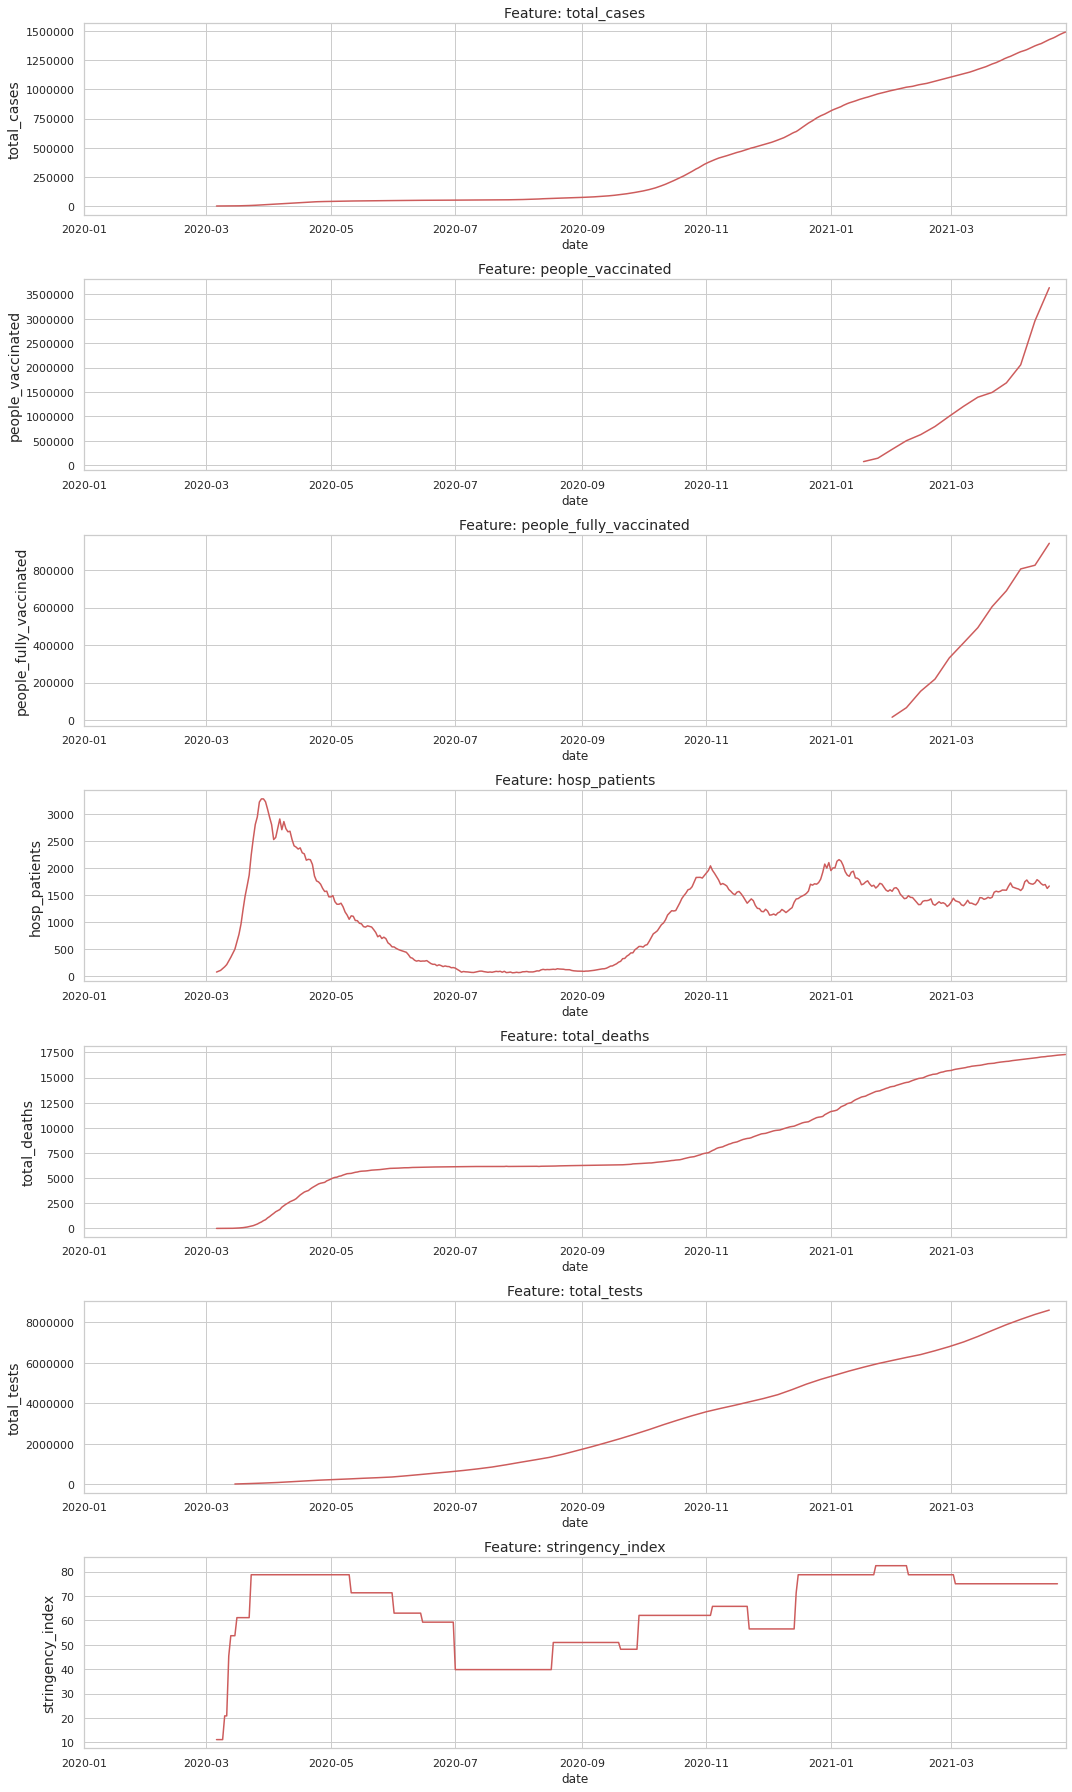

In [18]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))

for i, column in enumerate(df_n.drop(['date', 'location'], axis=1).columns):
    sns.lineplot(x=df_n['date'], y=df_n[column], ax=ax[i], color='indianred')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].ticklabel_format(style='plain', axis='y')
    
    ax[i].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])

fig.tight_layout()

## <center>4. Data Preprocessing 🔧</center>

### Checking Chronological Order and Ensuring Equidistant Timestamps

Since we are going to work with time series, we also need to make sure that the data is in chronological order and the timestamps are equidistant. The former will be checked by sorting the `DataFrame` object on the `date` column. The latter indicates constant time intervals which are an integral when it comes to predicting time-series. To check this, we will look at the difference between each timestamp and when it was taken.

In [19]:
df_n = df_n.sort_values(by='date')
df_n.head()

,date,location,total_cases,people_vaccinated,people_fully_vaccinated,hosp_patients,total_deaths,total_tests,stringency_index
0,2020-03-06,Netherlands,128.0,NaN,NaN,77.0,1.0,NaN,11.11
1,2020-03-07,Netherlands,188.0,NaN,NaN,93.0,1.0,NaN,11.11
2,2020-03-08,Netherlands,265.0,NaN,NaN,108.0,3.0,NaN,11.11
3,2020-03-09,Netherlands,321.0,NaN,NaN,141.0,3.0,NaN,11.11
4,2020-03-10,Netherlands,382.0,NaN,NaN,174.0,4.0,NaN,20.83


In [20]:
df_n['delta'] = df_n['date'] - df_n['date'].shift(1)
df_n[['date', 'delta']].head()

,date,delta
0,2020-03-06,NaT
1,2020-03-07,1 days
2,2020-03-08,1 days
3,2020-03-09,1 days
4,2020-03-10,1 days


In [21]:
df_n['delta'].sum(), df_n['delta'].count()

(Timedelta('416 days 00:00:00'), 416)

The data is already structurally sound and formatted. The timestamp interval is one day and the data is in chronological order.
***

### <center> 4.1 Handling Missing Values 💔</center>

Firstly, we should look into the `DataFrame` object and inspect where do we have missing values. We will replace them with `NaN` and fill them later on.

In [22]:
df_n = df_n.drop('delta', axis=1)
df_n.isna().sum()

date                         0
location                     0
total_cases                  0
people_vaccinated          403
people_fully_vaccinated    405
hosp_patients                9
total_deaths                 0
total_tests                359
stringency_index             4
dtype: int64

Next we should look into the amount of missing values and decide how should we fill them in.

In [23]:
df_n['stringency_index'] = df_n['stringency_index'].replace(0, np.nan)
df_n['people_vaccinated'] = df_n['people_vaccinated'].replace(0, np.nan)
df_n['people_fully_vaccinated'] = df_n['people_fully_vaccinated'].replace(0, np.nan)
df_n['hosp_patients'] = df_n['hosp_patients'].replace(0, np.nan)
df_n['total_tests'] = df_n['total_tests'].replace(0, np.nan)

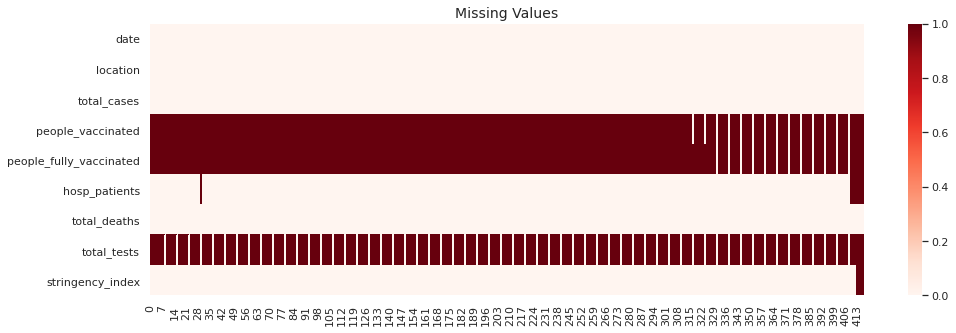

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))

sns.heatmap(df_n.T.isna(), cmap='Reds')
ax.set_title('Missing Values', fontsize=14)

plt.show()

We have a lot of missing values to deal with and we are going to explore 4 options:
* Option 1: Fill NaN with Outlier or Zero
* Option 2: Fill NaN with Mean Value
* Option 3: Fill NaN with Last Value with `.ffill()`
* Option 4: Fill NaN with Linearly Interpolated Value with `.interpolate()`

We will be exploring these options for only one feature and apply the same for the others due to the character of the missing values.

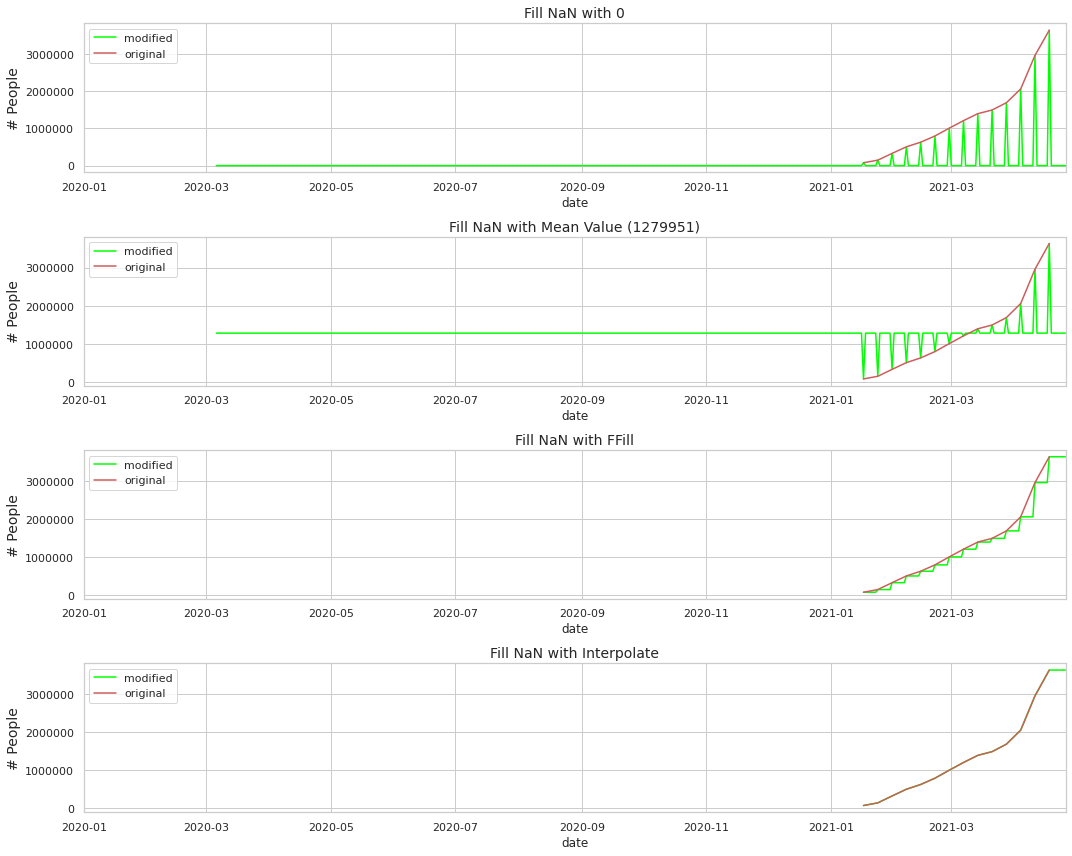

In [25]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'].fillna(0), ax=ax[0], color='lime', label = 'modified')
sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'], ax=ax[0], color='indianred', label = 'original')
ax[0].ticklabel_format(style='plain', axis='y')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='# People', fontsize=14)

mean_pv = df_n['people_vaccinated'].mean()
sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'].fillna(mean_pv), ax=ax[1], color='lime', label = 'modified')
sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'], ax=ax[1], color='indianred', label = 'original')
ax[1].ticklabel_format(style='plain', axis='y')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_pv:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='# People', fontsize=14)

sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'].ffill(), ax=ax[2], color='lime', label = 'modified')
sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'], ax=ax[2], color='indianred', label = 'original')
ax[2].ticklabel_format(style='plain', axis='y')
ax[2].set_title('Fill NaN with FFill', fontsize=14)
ax[2].set_ylabel(ylabel='# People', fontsize=14)

sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'].interpolate(), ax=ax[3], color='lime', label = 'modified')
sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'], ax=ax[3], color='indianred', label = 'original')
ax[3].ticklabel_format(style='plain', axis='y')
ax[3].set_title('Fill NaN with Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='# People', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])

fig.tight_layout()

We can also look how our missing values will look now after interpolating.

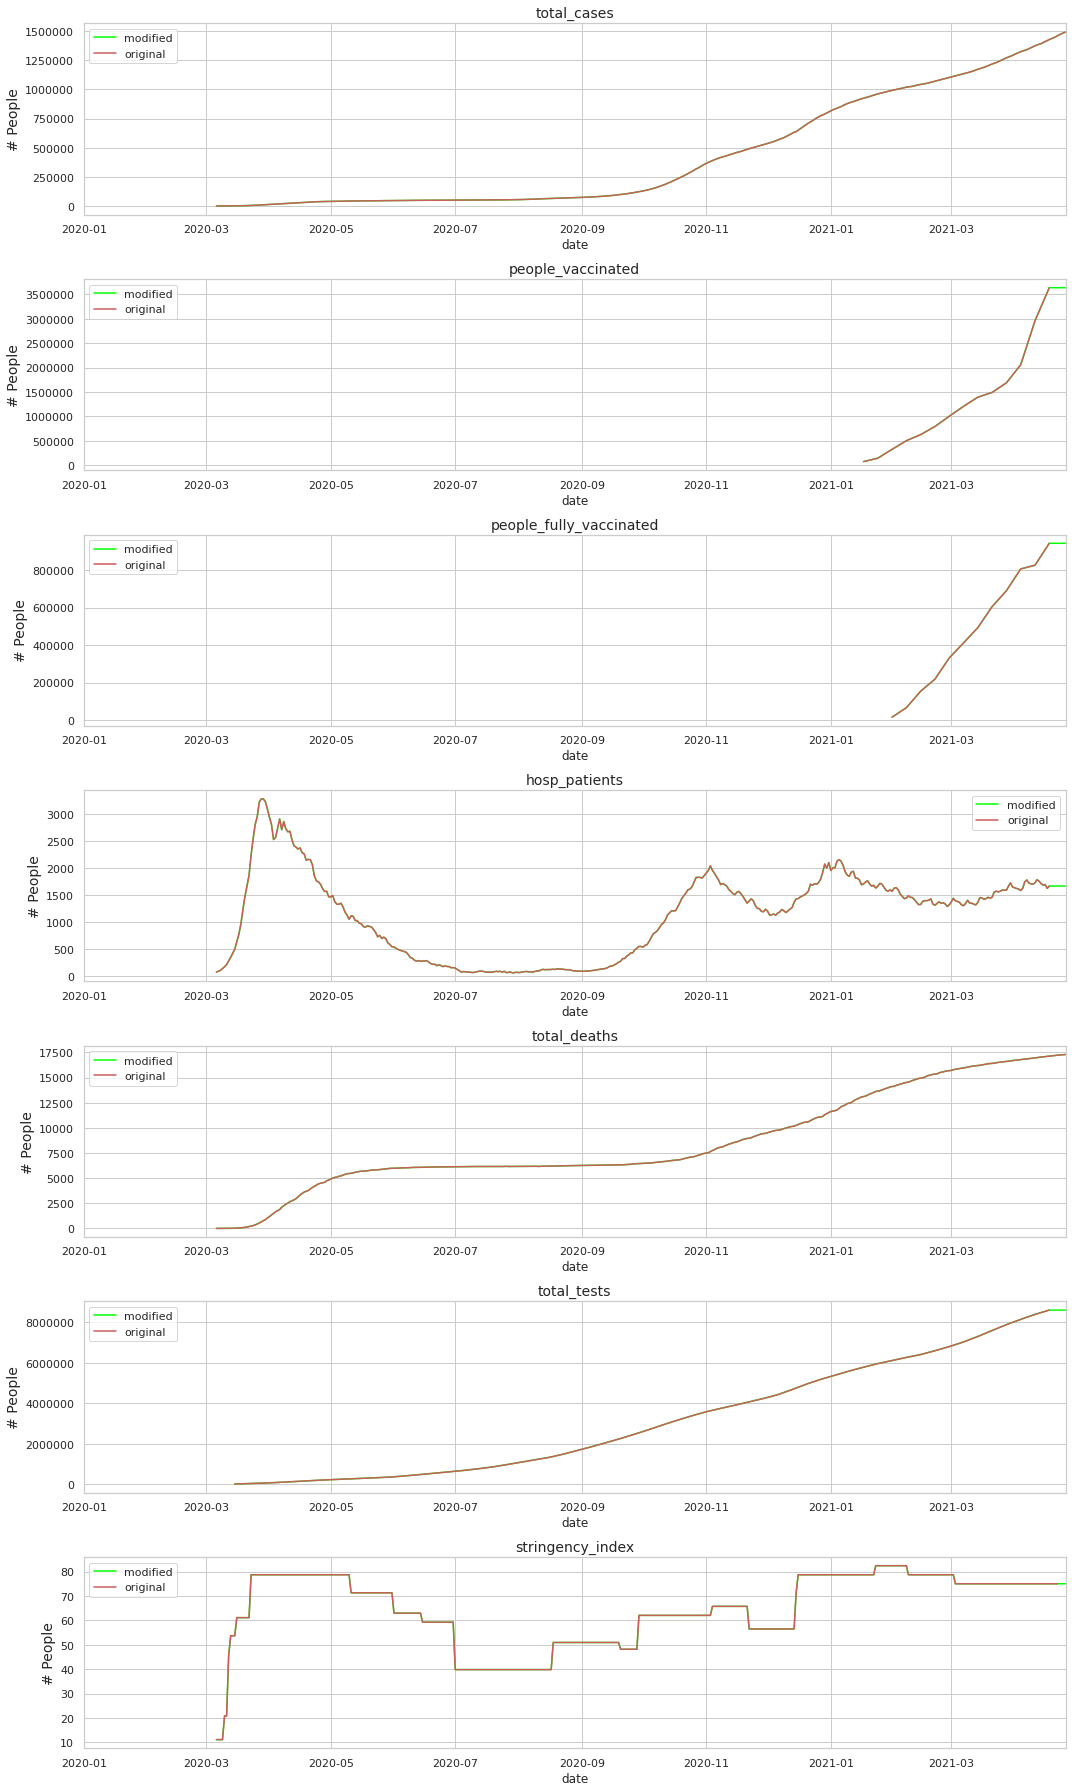

In [26]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))

for i, column in enumerate(df_n.drop(['date', 'location'], axis=1).columns):
    sns.lineplot(x=df_n['date'], y=df_n[column].interpolate(), ax=ax[i], color='lime', label = 'modified')
    sns.lineplot(x=df_n['date'], y=df_n[column], ax=ax[i], color='indianred', label = 'original')
    ax[i].ticklabel_format(style='plain', axis='y')
    ax[i].set_title('{}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel='# People', fontsize=14)
    ax[i].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])
    df_n[column].interpolate(inplace=True)
    
fig.tight_layout()

We will be using the `interpolate()` version of the filling since we want to "patch" the missing values.